## Flight Delay Prediction – Regression Analysis

This notebook explores a regression approach to predict flight arrival delays in minutes.
The objective is not to perfectly predict extreme delays, but to model typical operational behavior and understand the limitations of different regression models under a highly skewed target distribution.

### Objective

- Predict arrival delay (in minutes) using pre-flight information
- Compare linear and non-linear models
- Evaluate performance under skewed target distribution
- Emphasize interpretability and robustness over extreme cases


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from modules.cyclical_encoder import CyclicalEncoder
from modules.flight_preprocessor import FlightPreprocessor
from modules.smoothed_target_encoder import SmoothedTargetEncoder

In [2]:

RANDOM_STATE = 42
TEST_SIZE = 0.2

df_flights = pd.read_csv("./data/flights.csv", low_memory=False)
df_airports = pd.read_csv("./data/airports.csv", low_memory=False)

df_flights.columns = df_flights.columns.str.lower()
df_airports.columns = df_airports.columns.str.lower()
df_airports = df_airports[["iata_code", "state"]].copy()


# target (regressão): atraso na chegada
TARGET_COL = "arrival_delay"

processor = FlightPreprocessor()
df_flights = processor.preprocess(df_flights)

In [3]:
df_flights = (
    df_flights
    .merge(df_airports, how="left", left_on="origin_airport", right_on="iata_code")
    .rename(columns={"state": "state_origin"})
    .drop(columns=["iata_code"])
    .merge(df_airports, how="left", left_on="destination_airport", right_on="iata_code")
    .rename(columns={"state": "state_dest"})
    .drop(columns=["iata_code"])
)

base_features = [
    "airline",
    "origin_airport", "destination_airport",
    "state_origin", "state_dest",
    "distance",
    "scheduled_departure", "scheduled_arrival",
    "day_of_week", "month", "year",
]

df = df_flights[base_features + [TARGET_COL, "cancelled", "diverted"]].copy()

df = df[(df["cancelled"] == 0) & (df["diverted"] == 0)].copy()
df = df.dropna(subset=[TARGET_COL]).copy()

df[TARGET_COL] = df[TARGET_COL].clip(lower=0)

In [4]:
# ---------- Split primeiro (pra não vazar target no encoding) ----------
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

y_train = train_df[TARGET_COL].to_numpy()
y_test = test_df[TARGET_COL].to_numpy()

X_train = train_df.drop(columns=[TARGET_COL, "cancelled", "diverted"]).copy()
X_test  = test_df.drop(columns=[TARGET_COL, "cancelled", "diverted"]).copy()

### Feature Engineering

Feature engineering is divided into three groups:

1. Time-based features (hour, day of year)
2. Operational features (distance, route characteristics)
3. Encodings for categorical variables

In [5]:
# ---------- Time features + cyclical ----------
def add_time_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X["scheduled_departure"] = pd.to_datetime(X["scheduled_departure"], errors="coerce")
    X["scheduled_arrival"] = pd.to_datetime(X["scheduled_arrival"], errors="coerce")

    # departure
    X["dep_hour"] = X["scheduled_departure"].dt.hour + X["scheduled_departure"].dt.minute / 60
    X["dep_dayofyear"] = X["scheduled_departure"].dt.dayofyear

    # arrival
    X["arr_hour"] = X["scheduled_arrival"].dt.hour + X["scheduled_arrival"].dt.minute / 60
    X["arr_dayofyear"] = X["scheduled_arrival"].dt.dayofyear

    # remove datetimes brutos (evita colunas datetime no sklearn)
    X = X.drop(columns=["scheduled_departure", "scheduled_arrival"])
    return X

In [6]:
X_train = add_time_features(X_train)
X_test = add_time_features(X_test)

# cyclical encoding (fit no treino e aplica nos dois)
for col, period in [("dep_dayofyear", 365), ("dep_hour", 24), ("arr_dayofyear", 365), ("arr_hour", 24)]:
    enc = CyclicalEncoder(col, period=period)
    X_train = enc.fit_transform(X_train)
    X_test = enc.transform(X_test) if hasattr(enc, "transform") else enc.fit_transform(X_test)  # fallback


# ---------- Target encoding (fit no treino, transform no teste) ----------
cat_cols = ["origin_airport", "destination_airport", "airline", "state_origin", "state_dest"]

encoders = {
    "origin_airport": SmoothedTargetEncoder("origin_airport", TARGET_COL),
    "destination_airport": SmoothedTargetEncoder("destination_airport", TARGET_COL),
    "airline": SmoothedTargetEncoder("airline", TARGET_COL),
    "state_origin": SmoothedTargetEncoder("state_origin", TARGET_COL),
    "state_dest": SmoothedTargetEncoder("state_dest", TARGET_COL),
}


In [7]:
train_for_enc = pd.concat([X_train, train_df[[TARGET_COL]]], axis=1)
test_for_enc = pd.concat([X_test, test_df[[TARGET_COL]]], axis=1)  # target aqui só pra não quebrar interface, mas NÃO deve ser usado no fit

for col in cat_cols:
    if col not in X_train.columns:
        continue

    # fit no treino
    X_train[f"{col}_enc"] = encoders[col].fit_transform(train_for_enc)

    # transform no teste (ideal)
    if hasattr(encoders[col], "transform"):
        X_test[f"{col}_enc"] = encoders[col].transform(test_for_enc)
    else:
        # se sua classe não tem transform, recomendo MUITO adicionar.
        # fallback ruim: refaz fit_transform (vaza target) — evite.
        raise AttributeError(f"Seu SmoothedTargetEncoder não tem .transform() para a coluna {col}.")

# remove categóricas originais (agora que tem encoded)
X_train = X_train.drop(columns=[c for c in cat_cols if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in cat_cols if c in X_test.columns])

# garante que colunas batem
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

nan_train = X_train.isna().sum()
nan_train = nan_train[nan_train > 0].sort_values(ascending=False)

nan_test = X_test.isna().sum()
nan_test = nan_test[nan_test > 0].sort_values(ascending=False)

print("NaNs no treino:\n", nan_train.head(30))
print("\nNaNs no teste:\n", nan_test.head(30))

# % de linhas com pelo menos 1 NaN
pct_nan_rows_train = X_train.isna().any(axis=1).mean() * 100
pct_nan_rows_test = X_test.isna().any(axis=1).mean() * 100

print(f"% linhas com NaN (train): {pct_nan_rows_train:.2f}%")
print(f"% linhas com NaN (test):  {pct_nan_rows_test:.2f}%")

NaNs no treino:
 origin_airport_enc         984338
destination_airport_enc    984338
airline_enc                984338
state_origin_enc           984338
state_dest_enc             984338
dtype: int64

NaNs no teste:
 Series([], dtype: int64)
% linhas com NaN (train): 21.53%
% linhas com NaN (test):  0.00%


### Final Data Alignment and Imputation

Missing values are handled using statistics computed from the training set only, ensuring consistency and preventing data leakage.

In [8]:
# Final alignment
X_test = X_test.reindex(columns=X_train.columns)

num_cols = X_train.select_dtypes(include=[np.number]).columns
global_target_mean = y_train.mean()

# Numerical features → training median
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].median())

# Target-encoded features → global target mean
enc_cols = [c for c in X_train.columns if c.endswith("_enc")]
X_train[enc_cols] = X_train[enc_cols].fillna(global_target_mean)
X_test[enc_cols] = X_test[enc_cols].fillna(global_target_mean)

# Sanity check
assert not X_train.isna().any().any()
assert not X_test.isna().any().any()

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


Linear Regression is used as a baseline model to assess performance under linear assumptions.

In [11]:
# ---------- Model ----------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train_log)

# Predictions
y_pred_log = lin_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)  # avoid negative delay predictions

# ---------- Evaluation Metrics ----------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("### Model Evaluation Results (Test Set) ###")
print(f"MAE (primary metric): {mae:.2f}")
print(f"RMSE:                {rmse:.2f}")
print(f"R2:                  {r2:.4f}")

### Model Evaluation Results (Test Set) ###
MAE (primary metric): 12.54
RMSE:                37.01
R2:                  -0.0780


### Evaluation Metric Choice

Although multiple regression metrics are reported, **Mean Absolute Error (MAE)** is used as the primary evaluation metric.

Flight delays present a highly skewed distribution with a long tail, where extreme delays are rare but very large. In this context, metrics based on squared errors, such as RMSE, tend to be dominated by outliers and may overstate model error in typical operational scenarios.

MAE provides a more robust and interpretable measure, representing the average prediction error in minutes, and better reflects the model's performance for the majority of flights.


### Results Interpretation

The Linear Regression model achieves reasonable performance for small and moderate delays, but struggles with extreme values due to the skewed target distribution.
This behavior is expected and aligns with the model assumptions.

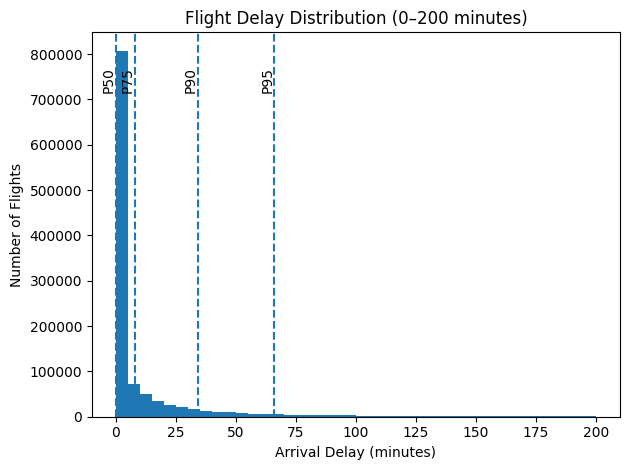

In [13]:
# Define percentiles to highlight
percentiles = [50, 75, 90, 95]
p_values = np.percentile(y_test, percentiles)

mask = y_test <= 200
plt.hist(y_test[mask], bins=40)
plt.title("Flight Delay Distribution (0–200 minutes)")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Number of Flights")

for p, v in zip(percentiles, p_values):
    if v <= 200:
        plt.axvline(v, linestyle="--")
        plt.text(
            v,
            plt.ylim()[1] * 0.85,
            f"P{p}",
            rotation=90,
            ha="right"
        )

plt.tight_layout()
plt.show()


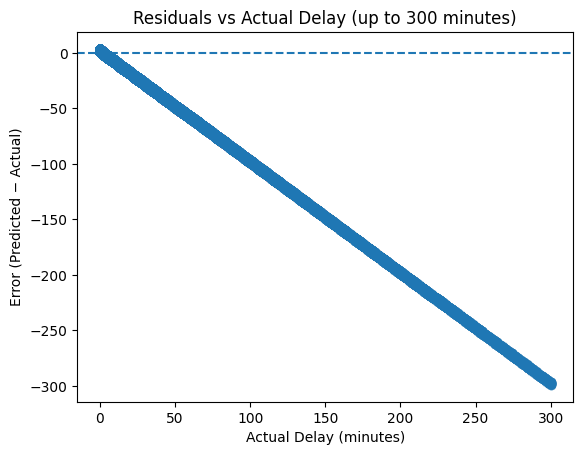

In [14]:
residuals = y_pred - y_test

mask = y_test <= 300
plt.scatter(y_test[mask], residuals[mask], alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Error (Predicted − Actual)")
plt.title("Residuals vs Actual Delay (up to 300 minutes)")
plt.show()

In [15]:
df_eval = pd.DataFrame({
    "y_real": y_test,
    "y_pred": y_pred
})

# Absolute error
df_eval["abs_error"] = np.abs(df_eval["y_real"] - df_eval["y_pred"])

# Delay bands
bins = [-np.inf, 0, 15, 60, np.inf]
labels = [
    "Early / On-time",
    "Minor delay (0–15)",
    "Moderate delay (15–60)",
    "Severe delay (>60)"
]

df_eval["delay_band"] = pd.cut(
    df_eval["y_real"],
    bins=bins,
    labels=labels
)

# MAE by delay band
mae_by_band = (
    df_eval
    .groupby("delay_band", observed=True)
    .agg(
        MAE=("abs_error", "mean"),
        Num_Flights=("abs_error", "count")
    )
    .reset_index()
)

mae_by_band


,delay_band,MAE,Num_Flights
0,Early / On-time,1.808869,725638
1,Minor delay (0–15),4.939011,212370
2,Moderate delay (15–60),29.251444,141149
3,Severe delay (>60),123.201234,63645


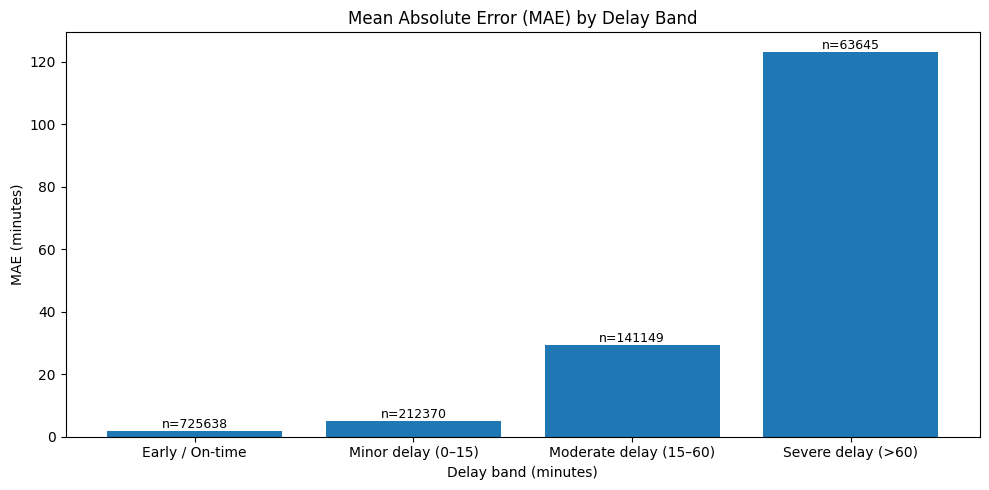

In [16]:
plt.figure(figsize=(10, 5))

plt.bar(
    mae_by_band["delay_band"].astype(str),
    mae_by_band["MAE"]
)

plt.xlabel("Delay band (minutes)")
plt.ylabel("MAE (minutes)")
plt.title("Mean Absolute Error (MAE) by Delay Band")

# Optional: show number of flights per band
for i, row in mae_by_band.iterrows():
    plt.text(
        i,
        row["MAE"],
        f'n={row["Num_Flights"]}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


The MAE increases with the severity of the delay, especially in rare extreme cases. 
However, for the most frequent delay bands, the error remains relatively low, 
reinforcing MAE as an appropriate metric for average operational performance.

## Conclusions

Flight delays present a highly skewed distribution with rare extreme events.
The baseline linear regression model performs reasonably well for small and moderate delays but systematically underestimates extreme cases.

Given this behavior, Mean Absolute Error (MAE) was chosen as the primary evaluation metric, as it better reflects average operational performance and is less influenced by rare outliers.

While the model is not suitable for predicting extreme delays, it provides meaningful insights for the majority of flights, highlighting the importance of metric choice and error analysis in skewed regression problems.
